# Parallelism


In [ ]:
from langchain_openai import AzureChatOpenAI
from langchain_core.messages import HumanMessage
from langgraph.types import Command
from langgraph.constants import Send
from typing import TypedDict, Literal
from typing_extensions import Annotated
import operator

In [12]:
llm = AzureChatOpenAI(model="gpt-4.1-mini")

In [ ]:
class OurCustomState(TypedDict):
    animals: list[str]
    jokes: Annotated[list, operator.add]

class JokeState(TypedDict):
    subject: str

In [14]:
def joke_generator(state:JokeState) -> str:
    print("Node: Joke")
    response = llm.invoke(input=[HumanMessage(content=f"Tell me a joke about {state['subject']}. Only return the joke, nothing else.")])

    return {
        "jokes": [response.content]
    }

In [ ]:
def random_animal_generator(state: OurCustomState) -> Command[Literal["joke_generator", "final_node"]]:
    print("Node: Random Animal")
    response = llm.invoke(input="Return 3 random animal names, comma separated.")
    animals = response.content.split(",")
    if len(animals) > 0:
        return Command(
            update={
                "animals": animals
            },
            goto=[
                Send(
                    node = "joke_generator",
                    arg = {
                        "subject": animal.strip()
                    }
                )
            for animal in animals]
        )
    else:
        return Command(
            update={
                "animals": []
            },
            goto=["final_node"]
        )

In [29]:
def final_node(state: OurCustomState):
    print("Node: Final")
    print("Animals:", state["animals"])
    print("Jokes:", state["jokes"])
    return {}

In [30]:
from langgraph.graph import StateGraph, START, END

builder = StateGraph(OurCustomState)

builder.add_node("random_animal_generator", random_animal_generator)
builder.add_node("joke_generator", joke_generator)
builder.add_node("final_node", final_node)

builder.add_edge(START, "random_animal_generator")
builder.add_edge("joke_generator", "final_node")
builder.add_edge("final_node", END)
graph = builder.compile()

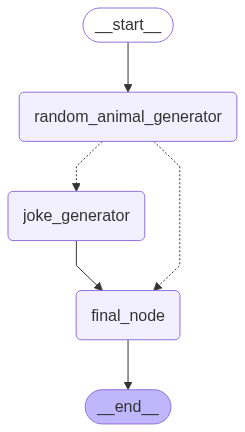

In [31]:
from IPython.display import Image
Image(graph.get_graph().draw_mermaid_png())

In [25]:
state = graph.invoke(input = {})

Node: Random Animal
Node: Final
Animals: []
Jokes: []


In [20]:
for joke in state["jokes"]:
    print(joke)